In [4]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import fastai
import numpy as np
from numpy import zeros, ones, flipud, log
from numpy.linalg import inv, eig, cholesky as chol
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import mean_squared_error
import pickle as pkl
from tqdm import tqdm
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.theta import ThetaModel

ModuleNotFoundError: No module named 'statsmodels.tsa.forecasting'

In [5]:
oex_tickers = ["AAPL", "ABBV", "ABT", "ACN","ADBE","AIG", "ALL", "AMGN", "AMT", "AMZN", "AXP", "BA", "BAC","BIIB","BK","BKNG","BLK","BMY","C","CAT","CHTR","CL","CMCSA","COF","COP","COST","CRM","CSCO","CVS","CVX","DD","DHR","DIS","DUK","EMR","EXC","F","FB","FDX","GD","GE","GILD","GM","GOOG","GOOGL","GS","HD","HON","IBM","INTC","JNJ","JPM","KHC","KMI","KO","LLY","LMT","LOW","MA","MCD","MDLZ","MDT","MET","MMM","MO","MRK","MS","MSFT","NEE","NFLX","NKE","NVDA","ORCL","OXY","PEP","PFE","PG","PM","PYPL","QCOM","RTX","SBUX","SLB","SO","SPG","T","TGT","TMO","UNH","UNP","UPS","USB","V","VZ","WBA","WFC","WMT","XOM"]

In [6]:
training_data = pd.read_pickle("data_dump/training_oex_5y_data.pkl")
training_data = training_data.drop(["OW", "BRK.B", "XN"])

In [5]:
from utils.general import training_data_for_t
from sklearn.linear_model import SGDRegressor
import time
from core import Position, PositionType
from utils.general import change_above_threshold

def liquidate_position(position, at_price, current_balance, verbose):
    updated_balance = current_balance

    # sell from previous buy
    if position.type == PositionType.BUY:
        updated_balance += (at_price * position.amount)
        log = 'Actual price is {} | Selling'.format(at_price)
#         print(log) if verbose else None

    # buy back from previous short
    if position.type == PositionType.SHORT:
        updated_balance -= (at_price * position.amount)
        log = 'Actual price is {} | Buying back'.format(at_price)
#         print(log) if verbose else None

    return updated_balance

def simulate_trades_returns(predictions, ground_truth, thresholds=None, slowed=False, verbose=False, print_result = False):
#     print(len(thresholds), len(ground_truth))
    assert len(thresholds) == len(ground_truth)
    ground_truth = ground_truth[1:]

    # tracking historic data
    balance_over_time = []

    balance = 200
    position = None
    n_trades = 0
    
    t = 0
    while t < len(ground_truth):
        curr_price = ground_truth[t]
        next_prediction = predictions[t]

        if position is not None:
            balance = liquidate_position(position, at_price=curr_price, current_balance=balance, verbose=verbose)

            # clear position and update data
            position = None

            n_trades += 1
            balance_over_time.append(balance)

            print('\nBalance: {}\n'.format(balance)) if verbose else None
#         if next_prediction == -1:
#             continue
        if next_prediction > 0:
            # check threshold
            if abs(next_prediction/curr_price) >= thresholds[t]:
                # buy and sell tomorrow
                position = Position(position_type=PositionType.BUY, amount=1)
                balance -= (curr_price * position.amount)

                log = 'Current price is {}, Predicting price at t+1 to be {} | Buying one share'.format(curr_price,
                                                                                                        next_prediction)
                print(log) if verbose else None
            else:
                balance_over_time.append(balance)

                log = 'Change not above threshold, not taking action'
                print(log) if verbose else None

        elif next_prediction < 0:
            # check threshold
            if abs(next_prediction/curr_price) >= thresholds[t]:
                # short and buy back tomorrow
                position = Position(position_type=PositionType.SHORT, amount=1)
                balance += (curr_price * position.amount)

                log = 'Current price is {}, Predicting price at t+1 to be {} | Shorting one share'.format(curr_price,
                                                                                                          next_prediction)
                print(log) if verbose else None
            else:
                balance_over_time.append(balance)

                log = 'Change not above threshold, not taking action'
                print(log) if verbose else None
        
            
        t = t + 1
        if slowed:
            time.sleep(2)

    # a position can be left over, so liquidate to get correct balance amount
    if position:
        balance = liquidate_position(position, at_price=ground_truth[-1], current_balance=balance, verbose=verbose)
        n_trades += 1
        balance_over_time.append(balance)

    log = 'Simulation done. Executed {} trades, Final Balance: {}'.format(n_trades, balance)
    print(log) if print_result else None

    return balance_over_time

ModuleNotFoundError: No module named 'utils'

In [6]:
import time
from core import Position, PositionType
from utils.general import change_above_threshold

"""
Liquidates a given Position and returns the new balance
"""


def liquidate_position(position, at_price, current_balance, verbose):
    updated_balance = current_balance

    # sell from previous buy
    if position.type == PositionType.BUY:
        updated_balance += (at_price * position.amount)
        log = 'Actual price is {} | Selling'.format(at_price)
        print(log) if verbose else None

    # buy back from previous short
    if position.type == PositionType.SHORT:
        updated_balance -= (at_price * position.amount)
        log = 'Actual price is {} | Buying back'.format(at_price)
        print(log) if verbose else None

    return updated_balance


"""
Simulation in format of:
    - If open position -> close by selling or buying back
    - Decide on next position
    - Repeat

Decisions to buy / sell happen continuously each day
"""


def simulate_trades_prices(predictions, ground_truth, thresholds=0, slowed=False, verbose=False):
    ground_truth = ground_truth[1:]

    # tracking historic data
    balance_over_time = []

    balance = 0
    position = None
    n_trades = 0

    t = 0
    while t < len(ground_truth):
        curr_price = ground_truth[t]
        next_prediction = predictions[t]

        if position is not None:
            balance = liquidate_position(position, at_price=curr_price, current_balance=balance, verbose=verbose)

            # clear position and update data
            position = None

            n_trades += 1
            balance_over_time.append(balance)

            print('\nBalance: {}\n'.format(balance)) if verbose else None

        if curr_price < next_prediction:
            # check threshold
            if change_above_threshold(curr_price, next_prediction, threshold=thresholds[t]):
                # buy and sell tomorrow
                position = Position(position_type=PositionType.BUY, amount=1)
                balance -= (curr_price * position.amount)

                log = 'Current price is {}, Predicting price at t+1 to be {} | Buying one share'.format(curr_price,
                                                                                                        next_prediction)
                print(log) if verbose else None
            else:
                balance_over_time.append(balance)

                log = 'Change not above threshold, not taking action'
                print(log) if verbose else None

        elif curr_price > next_prediction:
            # check threshold
            if change_above_threshold(curr_price, next_prediction, threshold=thresholds[t]):
                # short and buy back tomorrow
                position = Position(position_type=PositionType.SHORT, amount=1)
                balance += (curr_price * position.amount)

                log = 'Current price is {}, Predicting price at t+1 to be {} | Shorting one share'.format(curr_price,
                                                                                                          next_prediction)
                print(log) if verbose else None
            else:
                balance_over_time.append(balance)

                log = 'Change not above threshold, not taking action'
                print(log) if verbose else None

        t = t + 1
        if slowed:
            time.sleep(2)

    # a position can be left over, so liquidate to get correct balance amount
    if position:
        balance = liquidate_position(position, at_price=ground_truth[-1], current_balance=balance, verbose=verbose)
        n_trades += 1
        balance_over_time.append(balance)

    log = 'Simulation done. Executed {} trades, Final Balance: {}'.format(n_trades, balance)
    print(log)

    return balance_over_time

ModuleNotFoundError: No module named 'core'

In [8]:
from utils.general import training_data_for_t
from sklearn.linear_model import SGDRegressor
import time
from core import Position, PositionType
from utils.general import change_above_threshold

def liquidate_position(position, at_price, current_balance, verbose):
    updated_balance = current_balance

    # sell from previous buy
    if position.type == PositionType.BUY:
        updated_balance += (at_price * position.amount)
        log = 'Actual price is {} | Selling'.format(at_price)
#         print(log) if verbose else None

    # buy back from previous short
    if position.type == PositionType.SHORT:
        updated_balance -= (at_price * position.amount)
        log = 'Actual price is {} | Buying back'.format(at_price)
#         print(log) if verbose else None

    return updated_balance

def simulate_trades_returns_safepredict(predictions, ground_truth, safepredict_model, wp, losses, raw_losses = None, loss_function=None, thresholds=None, slowed=False, verbose=False, print_result = False, w0=None):
#     print(len(thresholds), len(ground_truth))
    assert len(thresholds) == len(ground_truth)
    ground_truth = ground_truth[1:]

    # tracking historic data
    balance_over_time = []

    balance = 200
    old_balance = 0
    position = None
    n_trades = 0
    loss = 0
    acceptance_prob = 0.5
    horizon = len(ground_truth)
    last_trade = 0
    
    t = 0
    while t < len(ground_truth):
        curr_price = ground_truth[t]
        next_prediction = predictions[t]
        

        if position is not None:
            old_balance = balance
#             print(old_balance)
            balance = liquidate_position(position, at_price=curr_price, current_balance=balance, verbose=verbose)
#             print(balance)
            # clear position and update data
            position = None

            n_trades += 1
            balance_over_time.append(balance)
            if balance < old_balance:
                if raw_losses is not None:
                    raw_losses.append(old_balance/balance)
#             print("raw loss: ", old_balance/balance)
                loss = np.log2(old_balance/balance)
                if loss_function is not None:
                    loss = loss_function(loss)
#             print("Loss being updated: ", loss)
                acceptance_prob = safepredict_model.update(loss)
#             print(acceptance_prob)
#             else:
#                 if raw_losses is not None:
#                     raw_losses.append(old_balance/balance)
#                 loss = np.log2(old_balance/balance)
#                 if loss_function is not None:
#                     loss = loss_function(loss)
#                 acceptance_prob = safepredict_model.update(loss)
            print('\nBalance: {}\n'.format(balance)) if verbose else None
#         if next_prediction == -1:
#             continue
        wp.append(acceptance_prob)
        if w0 is not None:
            w0.append(safepredict_model.w[0])
        losses.append(loss)
        accept = np.random.uniform()
#         if t-last_trade>30:
#             print("AMNESIA\n")
#             last_trade = t
#             safepredict_model = SafePredict(eps = loss_function(0.5), w0 = 0.5, alpha =1/len(ground_truth),horizon = len(ground_truth))
        if acceptance_prob >= accept:
            last_trade = t
            if next_prediction > 0:
                # check threshold
                if abs(next_prediction/curr_price) >= thresholds[t]:
                    # buy and sell tomorrow
                    position = Position(position_type=PositionType.BUY, amount=1)
                    balance -= (curr_price * position.amount)

                    log = 'Current price is {}, Predicting price at t+1 to be {} | Buying one share'.format(curr_price,
                                                                                                            next_prediction)
                    print(log) if verbose else None
                else:
                    balance_over_time.append(balance)

                    log = 'Change not above threshold, not taking action'
                    print(log) if verbose else None

            elif next_prediction < 0:
                # check threshold
                if abs(next_prediction/curr_price) >= thresholds[t]:
                    # short and buy back tomorrow
                    position = Position(position_type=PositionType.SHORT, amount=1)
                    balance += (curr_price * position.amount)

                    log = 'Current price is {}, Predicting price at t+1 to be {} | Shorting one share'.format(curr_price,
                                                                                                              next_prediction)
                    print(log) if verbose else None
                else:
                    balance_over_time.append(balance)

                    log = 'Change not above threshold, not taking action'
                    print(log) if verbose else None
        else:
            balance_over_time.append(balance)
            log = 'refused by SafePredict, not taking action'
            print(log) if verbose else None

            
        t = t + 1
        if slowed:
            time.sleep(2)

    # a position can be left over, so liquidate to get correct balance amount
    if position:
        balance = liquidate_position(position, at_price=ground_truth[-1], current_balance=balance, verbose=verbose)
        n_trades += 1
        balance_over_time.append(balance)

    log = 'Simulation done. Executed {} trades, Final Balance: {}'.format(n_trades, balance)
    print(log) if print_result else None

    return balance_over_time

ModuleNotFoundError: No module named 'utils'

In [10]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor


def fit_base_ensemble(models, X_train, X_val, y_train, y_val):
    meta_X = list()
    for name, model in models:
        model.fit(X_train, y_train)
        yhat = model.predict(X_val)
        yhat = yhat.reshape(len(yhat), 1)
        meta_X.append(yhat)
    meta_X = np.hstack(meta_X)
#     blender.fit(meta_X, y_val)
    return meta_X

def predict_base_ensemble(models, X_val):
    meta_X = list()
    for name, model in models:
        yhat = model.predict(X_val)
        yhat = yhat.reshape(len(yhat), 1)
        meta_X.append(yhat)
    meta_X = np.hstack(meta_X)
    return meta_X

def fit_meta_ensemble(meta_X, y_val, meta_model):
    meta_model.fit(meta_X, y_val)
    return meta_model

def fit_full_ensemble(models, X_train, X_val, y_train, y_val, meta_model):
    meta = fit_base_ensemble(models, X_train, X_val, y_train, y_val)
    return fit_meta_ensemble(meta, y_val, meta_model)


def predict_ensemble(models, blender, X_test):
    meta_X = list()
    for name, model in models:
        yhat = model.predict(X_test)
        yhat = yhat.reshape(len(yhat), 1)
        meta_X.append(yhat)
    meta_X = np.hstack(meta_X)
    return blender.predict(meta_X)

In [13]:
# ADAPTIVE SAFEPREDICT 
from math import exp, sqrt, log, tanh
class SafePredict:
    def __init__(self,  eps = 0.1, w0 = 0.5, alpha = 0, beta = 1, horizon = 1):
        # Initialize
        self.eps = eps        # Target error rate
        self.w0 = w0          # Initial weight of Dummy (i.e. 1- w_P)
        self.w = [w0, 1-w0]
        self.wPs = (1-w0)*w0
        self.alpha = alpha    # Adaptivity parameter: w_P >= alpha (default value 0)
        self.beta = beta      # Adaptivity parameter: w_P <= beta (default value 1)
        self.T = horizon      # Time horizon
        self.C = sqrt(-log(w0) - (self.T-1)*log(1-self.alpha)) / (1-self.eps) 
        self.k = 1 
        self.eta = self.C / 2**(self.k/2)


      
        
    def update(self, lP):
        # Update the weights, one data point at a time
        
        # Update the weights
        if self.wPs < 2**self.k:
            self.w[0] = self.w[0]*exp(-self.eta * self.eps); self.w[1] = self.w[1]*exp(-self.eta * lP); W = sum(self.w)
#             print("Internal probs: ",self.w[0], self.w[1])
            self.w[0] /= W; self.w[1] /= W
        else:
            self.w[0] = self.w0; self.w[1] = 1-self.w0
            self.k += 1
            self.eta = self.eta / sqrt(2)
            self.wPs = (1-self.w0)*self.w0
        
        
        # Mix the weights
        self.w[0] = self.w[0]*(self.beta-self.alpha) + 1 - self.beta 
        self.w[1] = self.w[1]*(self.beta-self.alpha) + self.alpha
        _w_1 = self.w[1]
        
        # Update the learning rate 
        self.wPs += self.w[1]*self.w[0]
        
        # Return the prediction probability
        return _w_1

In [12]:
from methods.svm import SVM
from preparers import ticker_default
from core.functions import forecast
from core.simulation import simulate_trades_continuous
from utils.viz import plot_time_series, plot_balance, plot_balance_vs_price
from utils.general import differentiate, inv_differentiate

ModuleNotFoundError: No module named 'methods'

 40%|████      | 342/854 [00:00<00:00, 3408.99it/s]

Predicting with no thresholding


100%|██████████| 854/854 [00:00<00:00, 3133.80it/s]


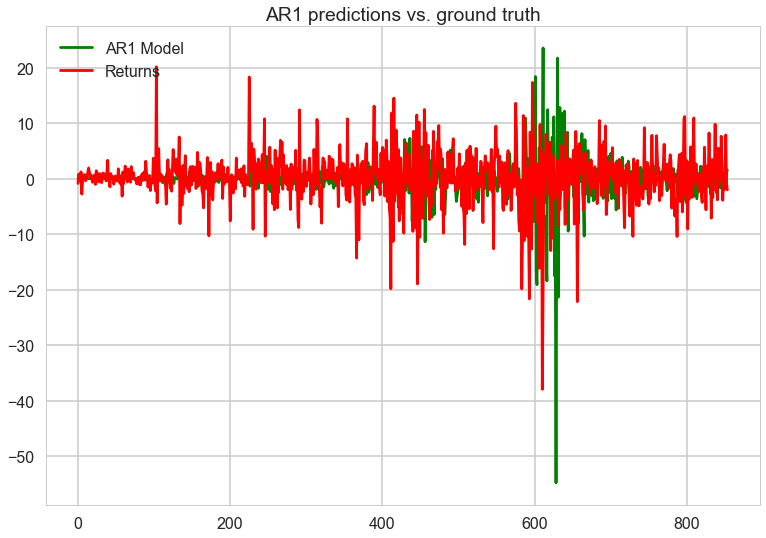

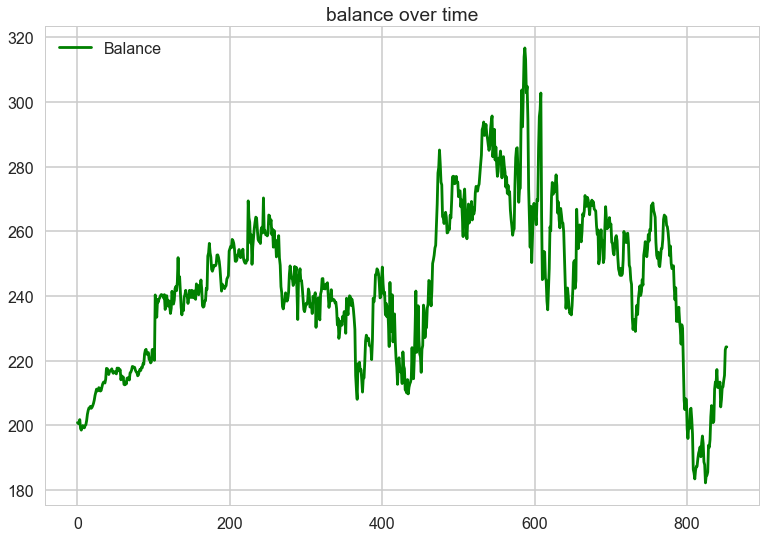

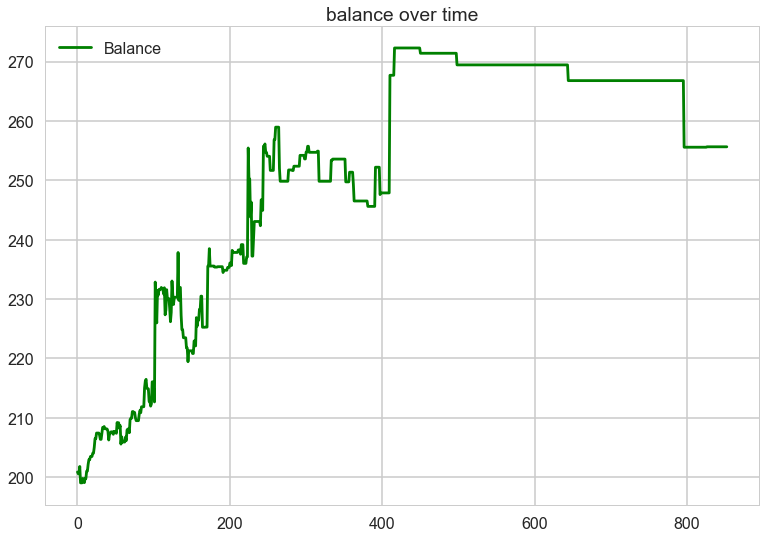

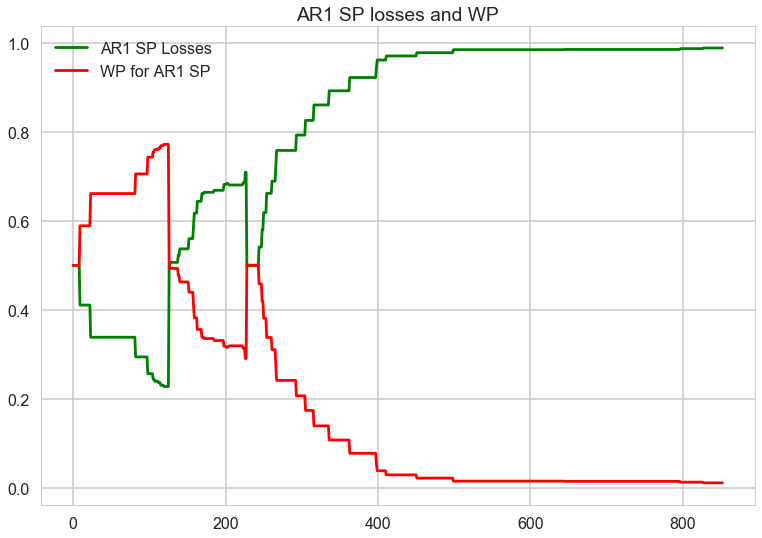

In [13]:
first_df = training_data.loc["NVDA"].dropna()
y_past = first_df[0:first_df.shape[0]-1]
y_current = first_df[1:first_df.shape[0]]
y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
x_features = []
x_features_raw=[]

num_days_year = 253
start_t = int(num_days_year/2)
num_features = int(0.2*start_t)
ground_truth, start_t = first_df[num_features:first_df.shape[0]-1], int(num_days_year/2)
num_features = int(0.2*start_t)

for i in range(y_features.shape[0] - num_features):
    current_i = i + num_features
    x_feature = []
    for j in range(num_features):
        x_feature.append(y_features[current_i-j-1])
    x_features_raw.append(x_feature)

# x_features = pd.DataFrame({'x': x_features_raw})
x_features = x_features_raw
y_features = y_features[num_features:y_features.shape[0]].reset_index(drop=True)

assert len(x_features) == len(y_features)
predictions_ar1 = []

thresholds = []
base_training_X = x_features[:start_t]
base_training_y = y_features[:start_t].reset_index(drop=True).to_numpy()
base_val_X = x_features[start_t:start_t*2]
base_val_y = y_features[start_t:start_t*2].reset_index(drop=True).to_numpy()
ar1 = SGDRegressor(shuffle=False, learning_rate='adaptive', eta0=0.0005)
ar1.partial_fit(base_training_X, base_training_y)
print("Predicting with no thresholding")
for t_i in tqdm(range(len(y_features) - start_t)):
    current_t = t_i + start_t
    threshold = 0
    thresholds.append(threshold)
    predictions_ar1.append(ar1.predict([x_features[current_t]])[0])
    ar1.partial_fit([x_features[current_t]], [y_features.iloc[current_t]])
    
def ar1_scaling_sp(loss):
    return ((0.4*loss) + 0.6)
    
    
epsilon = 0.5
w0 = 0.5
HORIZON = len(y_features) - start_t
ar1_sp = SafePredict(eps = ar1_scaling_sp(epsilon), w0 = w0, alpha =1/HORIZON,horizon = HORIZON)
ar1_losses = []
ar1_wp = []
ar1_w0 = []
ar1_raw = []

balances_ar1_sp = simulate_trades_returns_safepredict(predictions_ar1, ground_truth[start_t:], safepredict_model=ar1_sp, wp=ar1_wp, losses=ar1_losses, raw_losses=ar1_raw, loss_function=ar1_scaling_sp, thresholds=thresholds, w0 = ar1_w0)

balances_ar1 = simulate_trades_returns(predictions_ar1, ground_truth[start_t:], thresholds)

plot_time_series(ts_1=predictions_ar1, ts_label_1='AR1 Model', ts_2=y_features[start_t:], ts_label_2='Returns', title='AR1 predictions vs. ground truth')

plot_balance(data=balances_ar1)
plot_balance(data=balances_ar1_sp)
# print((ar1_wp))
plot_time_series(ts_1=ar1_w0, ts_label_1='AR1 SP Losses', ts_2=ar1_wp, ts_label_2='WP for AR1 SP', title='AR1 SP losses and WP')

In [14]:
specified_tickers = ["NVDA", "PYPL", "HON", "XOM"]
num_simulations = 1

In [15]:
vanilla_results = {}
for ticker in tqdm(specified_tickers):
    print(ticker)
    vanilla_results[ticker] = {}
    vanilla_results[ticker]["lr"] = []
    vanilla_results[ticker]["rfr"] = []
    vanilla_results[ticker]["ar1"] = []
    vanilla_results[ticker]["ar1_sp"] = []
    vanilla_results[ticker]["lr_weights"] = []
    vanilla_results[ticker]["arima"] = []
    vanilla_results[ticker]["arima_sp"] = []
    vanilla_results[ticker]["rfr_base"] = []
    vanilla_results[ticker]["rfr_base_sp"] = []
    vanilla_results[ticker]["theta"] = []
    vanilla_results[ticker]["theta_sp"] = []
    for i in tqdm(range(num_simulations)):
        #AR1
        print("AR1")
        first_df = training_data.loc[ticker].dropna()
        y_past = first_df[0:first_df.shape[0]-1]
        y_current = first_df[1:first_df.shape[0]]
        y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
        x_features = []
        x_features_raw=[]

        num_days_year = 253
        start_t = int(num_days_year/2)
        num_features = int(0.2*start_t)
        ground_truth, start_t = first_df[num_features:first_df.shape[0]-1], int(num_days_year/2)
        num_features = int(0.2*start_t)

        for i in range(y_features.shape[0] - num_features):
            current_i = i + num_features
            x_feature = []
            for j in range(num_features):
                x_feature.append(y_features[current_i-j-1])
            x_features_raw.append(x_feature)

        # x_features = pd.DataFrame({'x': x_features_raw})
        x_features = x_features_raw
        y_features = y_features[num_features:y_features.shape[0]].reset_index(drop=True)

        assert len(x_features) == len(y_features)
        predictions_ar1 = []

        thresholds = []
        base_training_X = x_features[:start_t]
        base_training_y = y_features[:start_t].reset_index(drop=True).to_numpy()
        base_val_X = x_features[start_t:start_t*2]
        base_val_y = y_features[start_t:start_t*2].reset_index(drop=True).to_numpy()
        ar1 = SGDRegressor(shuffle=False, learning_rate='adaptive', eta0=0.0005)
        ar1.partial_fit(base_training_X, base_training_y)
        for t_i in (range(len(y_features) - start_t)):
            current_t = t_i + start_t
            threshold = 0
            thresholds.append(threshold)
            predictions_ar1.append(ar1.predict([x_features[current_t]])[0])
            ar1.partial_fit([x_features[current_t]], [y_features.iloc[current_t]])

        def ar1_scaling_sp(loss):
            return ((0.4*loss) + 0.6)


        epsilon = 0.5
        w0 = 0.5
        HORIZON = len(y_features) - start_t
        ar1_sp = SafePredict(eps = ar1_scaling_sp(epsilon), w0 = w0, alpha =1/HORIZON,horizon = HORIZON)
        ar1_losses = []
        ar1_wp = []
        ar1_w0 = []
        ar1_raw = []

        balances_ar1_sp = simulate_trades_returns_safepredict(predictions_ar1, ground_truth[start_t:], safepredict_model=ar1_sp, wp=ar1_wp, losses=ar1_losses, raw_losses=ar1_raw, loss_function=ar1_scaling_sp, thresholds=thresholds, w0 = ar1_w0)

        balances_ar1 = simulate_trades_returns(predictions_ar1, ground_truth[start_t:], thresholds)
        vanilla_results[ticker]["ar1"].append(balances_ar1[len(balances_ar1)-1])
        vanilla_results[ticker]["ar1_sp"].append(balances_ar1_sp[len(balances_ar1_sp)-1])
        
        
        
        #ARIMA
        print("ARIMA")
        first_df = training_data.loc[ticker].dropna()
        y_past = first_df[0:first_df.shape[0]-1]
        y_current = first_df[1:first_df.shape[0]]
        y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
        x_features = pd.DataFrame({'x': list(y_features[0:y_features.shape[0]-1].to_numpy())})
        y_features = y_features[1:y_features.shape[0]].reset_index(drop=True)

        num_days_year = 253

        ground_truth, start_t = first_df[1:first_df.shape[0]-1].to_numpy(), int(num_days_year/2)
        assert len(x_features) == len(y_features)
        predictions_arima = []

        thresholds = []
        base_training_X = x_features[:start_t].reset_index(drop=True)
        base_training_y = y_features[:start_t].reset_index(drop=True)
        base_val_X = x_features[start_t:start_t*2].reset_index(drop=True)
        base_val_y = y_features[start_t:start_t*2].reset_index(drop=True)

        for t_i in (range(len(y_features) - start_t)):
            current_t = t_i + start_t
            threshold = 0
            thresholds.append(threshold)
            model = ARIMA(x_features[:current_t], order = (5,0,0))
            fitted_model = model.fit()
            prediction = fitted_model.forecast().reset_index(drop=True)
            predictions_arima.append(prediction[0])


        def arima_scaling_sp(loss):
            return ((0.4*loss) + 0.6)
        epsilon = 0.5
        w0 = 0.5
        HORIZON = len(y_features) - start_t
        arima_sp = SafePredict(eps = ar1_scaling_sp(epsilon), w0 = w0, alpha =1/HORIZON,horizon = HORIZON)
        arima_losses = []
        arima_wp = []

        balances_arima_sp = simulate_trades_returns_safepredict(predictions_arima, ground_truth[start_t:], safepredict_model=arima_sp, wp=arima_wp, losses=arima_losses, loss_function=arima_scaling_sp, thresholds=thresholds)

        balances_arima = simulate_trades_returns(predictions_arima, ground_truth[start_t:], thresholds)
        vanilla_results[ticker]["arima"].append(balances_arima[len(balances_arima)-1])
        vanilla_results[ticker]["arima_sp"].append(balances_arima_sp[len(balances_arima_sp)-1])

        #Theta
        print("Theta")
        first_df = training_data.loc[ticker].dropna()
        y_past = first_df[0:first_df.shape[0]-1]
        y_current = first_df[1:first_df.shape[0]]
        y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
        x_features = pd.DataFrame({'x': list(y_features[0:y_features.shape[0]-1].to_numpy())})
        y_features = y_features[1:y_features.shape[0]].reset_index(drop=True)

        num_days_year = 253

        ground_truth, start_t = first_df[1:first_df.shape[0]-1].to_numpy(), int(num_days_year/2)
        assert len(x_features) == len(y_features)
        predictions_theta_returns = []

        thresholds = []
        base_training_X = x_features[:start_t].reset_index(drop=True)
        base_training_y = y_features[:start_t].reset_index(drop=True)
        base_val_X = x_features[start_t:start_t*2].reset_index(drop=True)
        base_val_y = y_features[start_t:start_t*2].reset_index(drop=True)


        for t_i in (range(len(y_features) - start_t)):
            current_t = t_i + start_t
            threshold = 0
            thresholds.append(threshold)
            model = ThetaModel(y_features[:current_t],deseasonalize=False)
            fitted_model = model.fit()
            prediction = fitted_model.forecast().reset_index(drop=True)
            predictions_theta_returns.append(prediction[0])

        def theta_scaling_sp(loss):
            return ((0.4*loss) + 0.6)
        epsilon = 0.5
        w0 = 0.5
        HORIZON = len(y_features) - start_t
        theta_sp = SafePredict(eps = theta_scaling_sp(epsilon), w0 = w0, alpha =1/HORIZON,horizon = HORIZON)
        theta_losses = []
        theta_wp = []

        balances_theta_sp = simulate_trades_returns_safepredict(predictions_theta_returns, ground_truth[start_t:], safepredict_model=theta_sp, wp=theta_wp, losses=theta_losses, loss_function=theta_scaling_sp, thresholds=thresholds)

        balances_theta = simulate_trades_returns(predictions_theta_returns, ground_truth[start_t:], thresholds)

        vanilla_results[ticker]["theta"].append(balances_theta[len(balances_theta)-1])
        vanilla_results[ticker]["theta_sp"].append(balances_theta_sp[len(balances_theta_sp)-1])
        
        #RFR
        print("RFR")
        #RFR WITH 0.2*START_T NUM_FEATURES, TRAINED ON ALL HISTORIC DATA
        first_df = training_data.loc[ticker].dropna()
        y_past = first_df[0:first_df.shape[0]-1]
        y_current = first_df[1:first_df.shape[0]]
        y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
        x_features = []
        x_features_raw=[]

        num_days_year = 253

        ground_truth, start_t = first_df[num_features:first_df.shape[0]-1], int(num_days_year/2)
        num_features = int(0.2*start_t)

        for i in range(y_features.shape[0] - num_features):
            current_i = i + num_features
            x_feature = []
            for j in range(num_features):
                x_feature.append(y_features[current_i-j-1])
            x_features_raw.append(x_feature)

        # x_features = pd.DataFrame({'x': x_features_raw})
        x_features = x_features_raw
        y_features = y_features[num_features:y_features.shape[0]].reset_index(drop=True)
        assert len(x_features) == len(y_features)
        predictions_rfr = []

        thresholds = []
        base_training_X = x_features[:start_t]
        base_training_y = y_features[:start_t].reset_index(drop=True)
        base_val_X = x_features[start_t:start_t*2]
        base_val_y = y_features[start_t:start_t*2].reset_index(drop=True)

        rfr = RandomForestRegressor(bootstrap=False)
        rfr.fit(base_training_X, base_training_y)

        for t_i in (range(len(y_features) - start_t)):
            current_t = t_i + start_t
            threshold = 0
            thresholds.append(threshold)
            rfr.fit(x_features[:current_t], y_features[:current_t].to_numpy())
            predictions_rfr.append(rfr.predict([x_features[current_t]]))
        def rfr_scaling_sp(loss):
            return ((0.4*loss) + 0.6)


        epsilon = 0.5
        w0 = 0.5
        HORIZON = len(y_features) - start_t
        rfr_sp = SafePredict(eps = rfr_scaling_sp(epsilon), w0 = w0, alpha =1/HORIZON,horizon = HORIZON)
        rfr_losses = []
        rfr_wp = []

        balances_rfr_sp = simulate_trades_returns_safepredict(predictions_rfr, ground_truth[start_t:], safepredict_model=rfr_sp, wp=rfr_wp, losses=rfr_losses, loss_function=rfr_scaling_sp, thresholds=thresholds)

        balances_rfr = simulate_trades_returns(predictions_rfr, ground_truth[start_t:], thresholds)


        vanilla_results[ticker]["rfr_base"].append(balances_rfr[len(balances_rfr)-1])
        vanilla_results[ticker]["rfr_base_sp"].append(balances_rfr_sp[len(balances_rfr_sp)-1])

        #LR META MODEL
#         print("LR Meta")
#         first_df = training_data.loc[ticker].dropna()
#         y_past = first_df[0:first_df.shape[0]-1]
#         y_current = first_df[1:first_df.shape[0]]
#         y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
#         x_features = pd.DataFrame({'x': list(y_features[0:y_features.shape[0]-1].to_numpy())})
#         y_features = y_features[1:y_features.shape[0]].reset_index(drop=True)

#         num_days_year = 253

#         ground_truth, start_t = first_df[1:first_df.shape[0]-1].to_numpy(), int(num_days_year/2)
#         assert len(x_features) == len(y_features)
#         thresholds = []
#         meta_model_lr = SGDRegressor(fit_intercept=False)

#         # returns_arima = np.subtract(predictions_arima, data[start_t:].reset_index(drop=True))
#         all_predictions = [predictions_ar1, predictions_arima, predictions_rfr, predictions_theta_returns]
#         meta_X = []
#         for i in range(start_t):
#             meta_X_instance = [all_predictions[0][i][0], all_predictions[1][i], all_predictions[2][i][0], all_predictions[3][i]]
#             meta_X.append(meta_X_instance)

#         meta_model_lr.partial_fit(meta_X, y_features[start_t:start_t*2])
#         predictions_meta_lr = []
#         for t_i in (range(len(y_features) - start_t*2)):
#             current_t = t_i + start_t
#             threshold = 0
#             thresholds.append(threshold)
#             vanilla_results[ticker]["lr_weights"].append(meta_model_lr.coef_)
#             prediction = meta_model_lr.predict([[all_predictions[0][current_t][0], all_predictions[1][current_t], all_predictions[2][current_t][0], all_predictions[3][current_t]]])
#             predictions_meta_lr.append(prediction)
#             meta_model_lr.partial_fit([[all_predictions[0][current_t][0], all_predictions[1][current_t], all_predictions[2][current_t][0], all_predictions[3][current_t]]], [y_features.iloc[current_t]])


#         balances_meta_lr = simulate_trades_returns(predictions_meta_lr, ground_truth[start_t*2:], thresholds)
#         vanilla_results[ticker]["lr"].append(balances_meta_lr[len(balances_meta_lr)-1])
        
#         #RFR Meta Model
#         print("RFR Meta") 
#         first_df = training_data.loc[ticker].dropna()
#         y_past = first_df[0:first_df.shape[0]-1]
#         y_current = first_df[1:first_df.shape[0]]
#         y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
#         x_features = pd.DataFrame({'x': list(y_features[0:y_features.shape[0]-1].to_numpy())})
#         y_features = y_features[1:y_features.shape[0]].reset_index(drop=True)

#         num_days_year = 253

#         ground_truth, start_t = first_df[1:first_df.shape[0]-1].to_numpy(), int(num_days_year/2)
#         assert len(x_features) == len(y_features)
#         thresholds = []
#         meta_model_rfr = RandomForestRegressor(bootstrap=False)

#         # returns_arima = np.subtract(predictions_arima, data[start_t:].reset_index(drop=True))
#         all_predictions = [predictions_ar1, predictions_arima, predictions_rfr, predictions_theta_returns]
#         meta_X = []
#         for i in range(start_t):
#             meta_X_instance = [all_predictions[0][i][0], all_predictions[1][i], all_predictions[2][i][0], all_predictions[3][i]]
#             meta_X.append(meta_X_instance)

#         meta_model_rfr.fit(meta_X, y_features[start_t:start_t*2])
#         predictions_meta_rfr = []
#         for t_i in (range(len(y_features) - start_t*2)):
#             current_t = t_i + start_t
#             threshold = 0
#             thresholds.append(threshold)
#             meta_model_rfr.fit(meta_X, y_features[:current_t])
#             meta_X.append([all_predictions[0][current_t][0], all_predictions[1][current_t], all_predictions[2][current_t][0], all_predictions[3][current_t]])
#             prediction = meta_model_rfr.predict([[all_predictions[0][current_t][0], all_predictions[1][current_t], all_predictions[2][current_t][0], all_predictions[3][current_t]]])
#             predictions_meta_rfr.append(prediction)


#         balances_meta_rfr = simulate_trades_returns(predictions_meta_rfr, ground_truth[start_t*2:], thresholds)
#         vanilla_results[ticker]["rfr"].append(balances_meta_rfr[len(balances_meta_rfr)-1])
        

  0%|          | 0/1 [00:00<?, ?it/s]

NVDA
AR1
ARIMA
Theta
RFR



  0%|          | 0/1 [00:00<?, ?it/s]

PYPL
AR1
ARIMA
Theta
RFR



  0%|          | 0/1 [00:00<?, ?it/s]

HON
AR1
ARIMA
Theta
RFR



  0%|          | 0/1 [00:00<?, ?it/s]

XOM
AR1
ARIMA
Theta
RFR



100%|██████████| 4/4 [1:42:35<00:00, 1539.00s/it]


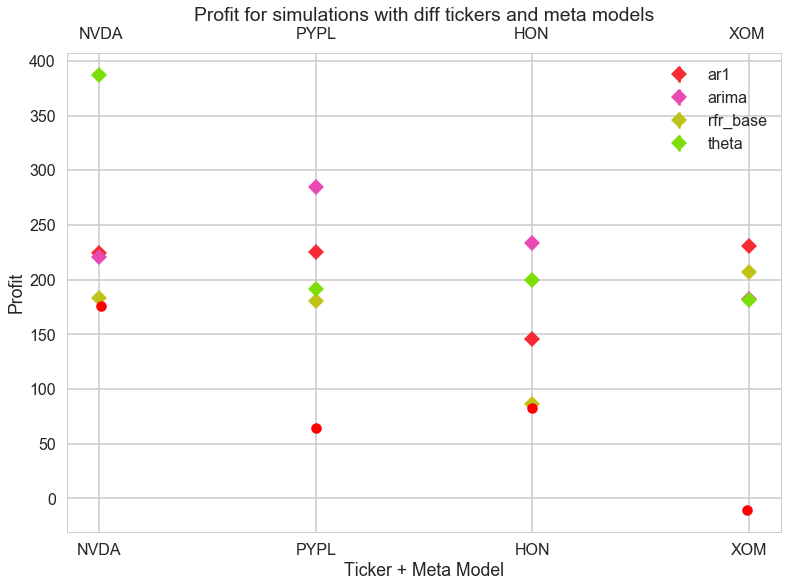

In [20]:
buy_and_hold = []
vanilla_results_mean = []
vanilla_results_std = []
labels = []
final_results_mean = []
final_results_std = []
legend = ["ar1", "arima", "rfr_base", "theta"]
# legend = ["ar1_sp", "arima_sp", "rfr_base_sp", "theta_sp"]
results_mean = {}
results_std = {}
for label in legend:
    type_mean = []
    type_std = []
    for ticker in specified_tickers:
        type_mean.append(np.mean(np.asarray(vanilla_results[ticker][label])))
        type_std.append(np.std(np.asarray(vanilla_results[ticker][label])))
    results_mean[label] = type_mean
    results_std[label] = type_std


for ticker in specified_tickers:
    prices=training_data.loc[ticker].dropna()
    buy_and_hold.append(prices[prices.shape[0]-1] - prices[0])
    labels.append(ticker)
    
fig, ax = plt.subplots()
ax2 = ax.twiny()
ax2.scatter(labels, buy_and_hold, s= 100, c='r')
ax2.grid(False)
for label in legend:
    ax.errorbar(labels, results_mean[label], yerr=results_std[label], fmt='D', c = np.random.rand(3), label=label)

ax.legend()    
# ax.errorbar(labels, final_results_mean, yerr=final_results_std, fmt='o')
ax.set_xlabel('Ticker + Meta Model')
ax.set_ylabel('Profit')
ax.set_title('Profit for simulations with diff tickers and meta models')
ax.grid(True)
plt.show()

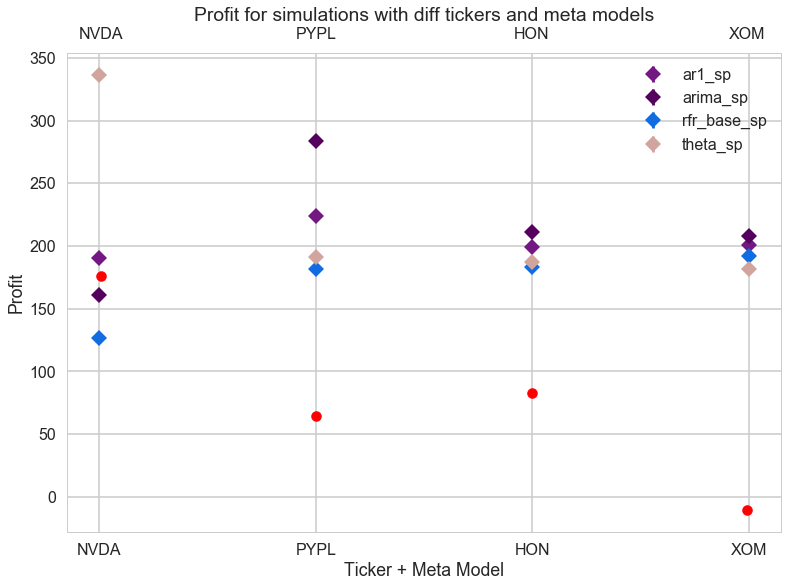

In [21]:
buy_and_hold = []
vanilla_results_mean = []
vanilla_results_std = []
labels = []
final_results_mean = []
final_results_std = []
# legend = ["ar1", "arima", "rfr_base", "theta"]
legend = ["ar1_sp", "arima_sp", "rfr_base_sp", "theta_sp"]
results_mean = {}
results_std = {}
for label in legend:
    type_mean = []
    type_std = []
    for ticker in specified_tickers:
        type_mean.append(np.mean(np.asarray(vanilla_results[ticker][label])))
        type_std.append(np.std(np.asarray(vanilla_results[ticker][label])))
    results_mean[label] = type_mean
    results_std[label] = type_std


for ticker in specified_tickers:
    prices=training_data.loc[ticker].dropna()
    buy_and_hold.append(prices[prices.shape[0]-1] - prices[0])
    labels.append(ticker)
    
fig, ax = plt.subplots()
ax2 = ax.twiny()
ax2.scatter(labels, buy_and_hold, s= 100, c='r')
ax2.grid(False)
for label in legend:
    ax.errorbar(labels, results_mean[label], yerr=results_std[label], fmt='D', c = np.random.rand(3), label=label)

ax.legend()    
# ax.errorbar(labels, final_results_mean, yerr=final_results_std, fmt='o')
ax.set_xlabel('Ticker + Meta Model')
ax.set_ylabel('Profit')
ax.set_title('Profit for simulations with diff tickers and meta models')
ax.grid(True)
plt.show()